# DSCI 100 Project Proposal: Pulsars

## Introduction

## Preliminary Exploratory Data Analysis

In [1]:
# Uncomment code below to install packages
# install.packages(tidyverse)
# install.packages(tidymodels)

In [2]:
# Import packages
library(tidyverse)
library(tidymodels)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.11     ✔ rsample      0.1.1 
✔ dials        0.1.0      ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.1.7      ✔ yardstick    0.0.9 
✔ recipes      0.1.17     

── Conflicts ──────────────────────────────────

In [3]:
# Read csv file
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Rows: 17898 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [4]:
# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decide to split dataset into 75% training and 25% testing

htru_split <- initial_split(htru_data, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

Rows: 13,423
Columns: 9
$ mean_ip        <dbl> 140.56250, 102.50781, 103.01562, 136.75000, 88.72656, 9…
$ sd_ip          <dbl> 55.68378, 58.88243, 39.34165, 57.17845, 40.67223, 46.69…
$ kurtosis_ip    <dbl> -0.234571412, 0.465318154, 0.323328365, -0.068414638, 0…
$ skew_ip        <dbl> -0.69964840, -0.51508791, 1.05116443, -0.63623837, 1.12…
$ mean_dmsnr     <dbl> 3.1998328, 1.6772575, 3.1212375, 3.6429766, 1.1789298, …
$ sd_dmsnr       <dbl> 19.110426, 14.860146, 21.744669, 20.959280, 11.468720, …
$ kurtosis_dmsnr <dbl> 7.975532, 10.576487, 7.735822, 6.896499, 14.269573, 10.…
$ skew_dmsnr     <dbl> 74.24222, 127.39358, 63.17191, 53.59366, 252.56731, 131…
$ class          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
Rows: 4,475
Columns: 9
$ mean_ip        <dbl> 133.25781, 100.85156, 100.89062, 112.71875, 108.03906, …
$ sd_ip          <dbl> 44.05824, 51.74352, 51.89039, 50.30127, 34.91024, 45.93…
$ kurtosis_ip    <dbl> -0.08105986, 0.39383679, 0.62748653, 0.27939095, 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



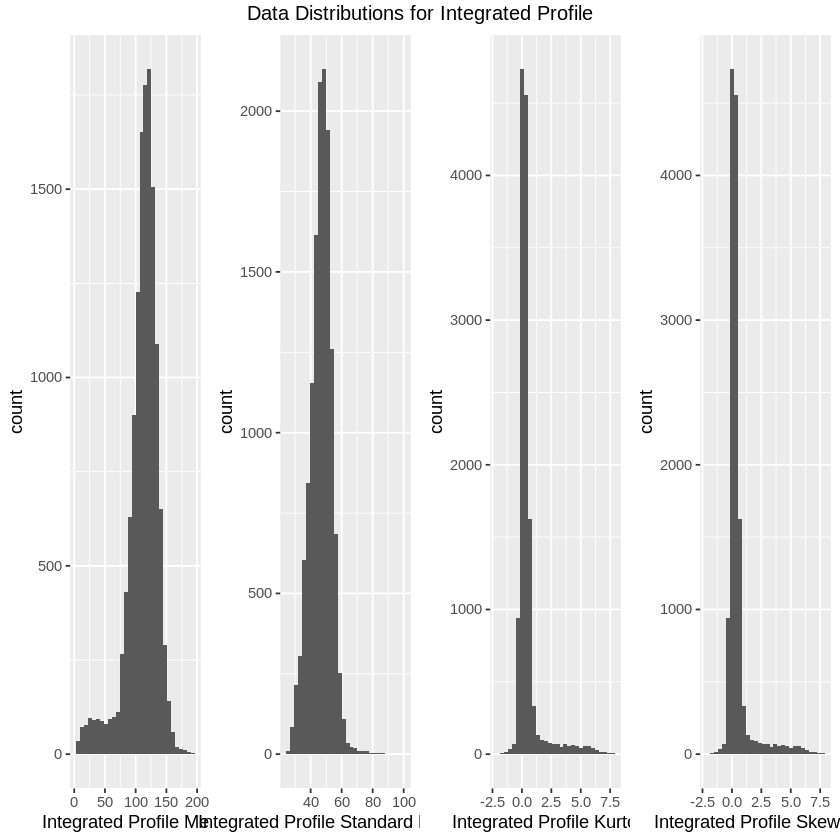

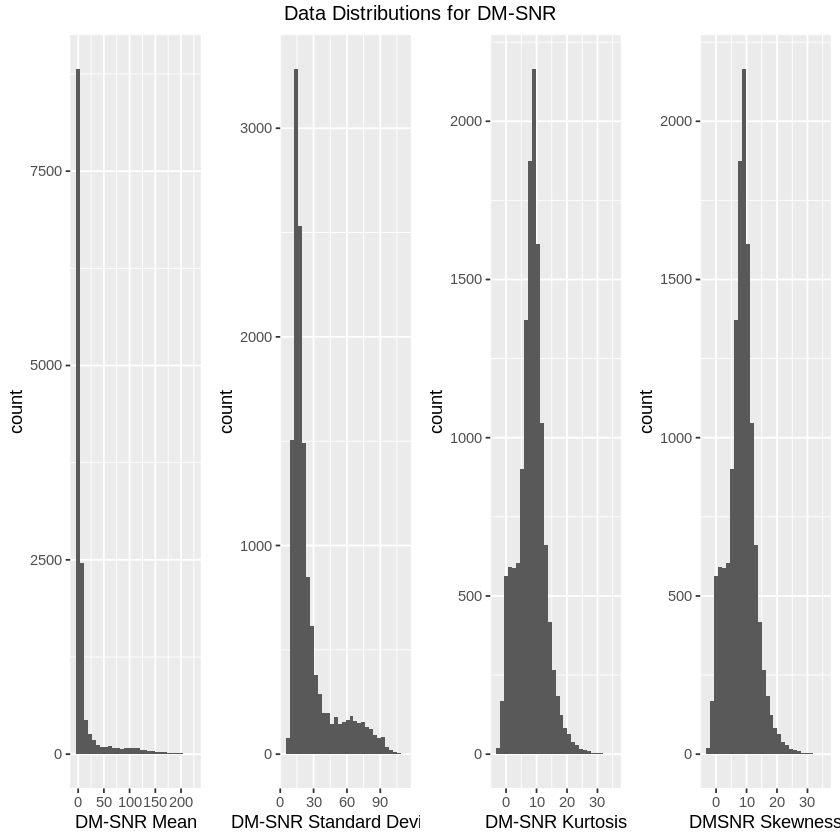

In [11]:
library(gridExtra)

vis_mean_ip <- ggplot(htru_train, aes(x = mean_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Mean')
vis_sd_ip <- ggplot(htru_train, aes(x = sd_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Standard Deviation')
vis_kurtosis_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Kurtosis')
vis_skew_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Skewness')
vis_mean_dmsnr <- ggplot(htru_train, aes(x = mean_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Mean')
vis_sd_dmsnr <- ggplot(htru_train, aes(x = sd_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Standard Deviation')
vis_kurtosis_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Kurtosis')
vis_skew_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DMSNR Skewness')

# can someone please fix the dimension sizes thanks
grid.arrange(vis_mean_ip, vis_sd_ip, vis_kurtosis_ip, vis_skew_ip, nrow = 1, top = 'Data Distributions for Integrated Profile')
grid.arrange(vis_mean_dmsnr, vis_sd_dmsnr, vis_kurtosis_dmsnr, vis_skew_dmsnr, nrow = 1, top = 'Data Distributions for DM-SNR')

## Methods

## Expected Outcomes and Significance